In [1]:
from fastkaggle import get_dataset
from pathlib import Path
from fastai.tabular.all import *

In [2]:
path = Path('data/dbscan')
dataset = 'vjchoudhary7/customer-segmentation-tutorial-in-python'

In [3]:
if not path.exists():
    data = get_dataset(path, dataset, unzip=True)

In [4]:
df = pd.read_csv(path/'Mall_Customers.csv', low_memory=False)

In [5]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


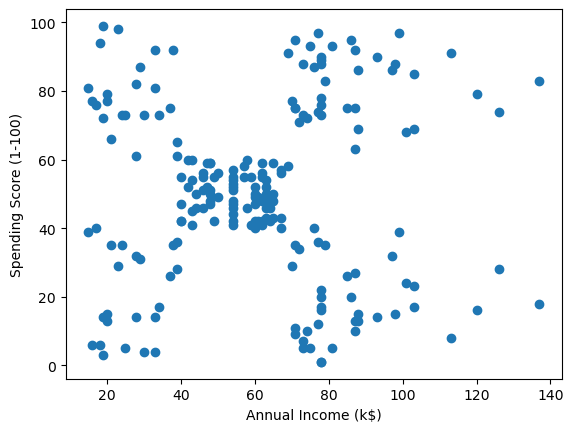

In [6]:
x = df['Annual Income (k$)']
y = df['Spending Score (1-100)']
plt.scatter(x,y)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

In [7]:
x_y_tens = torch.from_numpy(df.to_numpy()[:,3:].astype(float)).to("cuda")

In [8]:
k = 5

## Randomly Select 3 Data Points

In [9]:
sample_idxs = torch.randperm(x_y_tens.shape[0])[:5]
centroids = x_y_tens[sample_idxs]
centroids


tensor([[34., 17.],
        [54., 54.],
        [21., 66.],
        [58., 46.],
        [34., 73.]], device='cuda:0', dtype=torch.float64)

In [10]:
og_centroids = centroids.clone()

In [11]:
def np_detach(tens):
    return tens.detach().cpu().numpy()

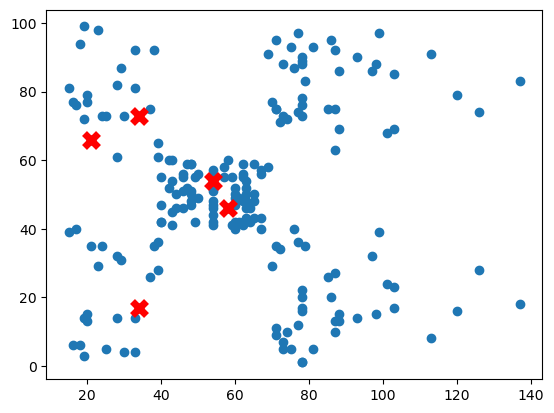

In [12]:
x = np_detach(x_y_tens)[:,0]
y = np_detach(x_y_tens)[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)
for cen in centroids:
    ax.plot(np_detach(cen)[0], np_detach(cen)[1], markersize=10, marker="x", color='r', mew=5)
    

In [13]:
(x_y_tens - centroids[0])

tensor([[-19.,  22.],
        [-19.,  64.],
        [-18., -11.],
        [-18.,  60.],
        [-17.,  23.],
        [-17.,  59.],
        [-16., -11.],
        [-16.,  77.],
        [-15., -14.],
        [-15.,  55.],
        [-15.,  -3.],
        [-15.,  82.],
        [-14.,  -2.],
        [-14.,  60.],
        [-14.,  -4.],
        [-14.,  62.],
        [-13.,  18.],
        [-13.,  49.],
        [-11.,  12.],
        [-11.,  81.],
        [-10.,  18.],
        [-10.,  56.],
        [ -9., -12.],
        [ -9.,  56.],
        [ -6.,  -3.],
        [ -6.,  65.],
        [ -6.,  15.],
        [ -6.,  44.],
        [ -5.,  14.],
        [ -5.,  70.],
        [ -4., -13.],
        [ -4.,  56.],
        [ -1., -13.],
        [ -1.,  75.],
        [ -1.,  -3.],
        [ -1.,  64.],
        [  0.,   0.],
        [  0.,  56.],
        [  3.,   9.],
        [  3.,  58.],
        [  4.,  18.],
        [  4.,  75.],
        [  5.,  19.],
        [  5.,  44.],
        [  5.,  11.],
        [ 

In [14]:
x_y_tens[0]

tensor([15., 39.], device='cuda:0', dtype=torch.float64)

In [15]:
x_y_tens.shape, centroids.shape

(torch.Size([200, 2]), torch.Size([5, 2]))

To calculate the Euclidean distance between two matrices A and B using the Frobenius norm, you first subtract one matrix from the other element-wise to obtain a matrix C, where C(i,j) = A(i,j) - B(i,j). Then, you compute the Frobenius norm of matrix C:

dist = ||C||F

This distance metric quantifies the dissimilarity between the two matrices in terms of the overall magnitude of their differences. The smaller the distance, the more similar the matrices are in terms of their element values.

It's worth noting that when working with vectors (1-dimensional matrices), the Frobenius norm reduces to the usual Euclidean norm.

In [16]:
(x_y_tens.unsqueeze(1) - centroids.unsqueeze(0)).shape

torch.Size([200, 5, 2])

In [17]:
(x_y_tens.unsqueeze(1) - centroids.unsqueeze(0))[-1]

tensor([[103.,  66.],
        [ 83.,  29.],
        [116.,  17.],
        [ 79.,  37.],
        [103.,  10.]], device='cuda:0', dtype=torch.float64)

## Calculate the Frobenius norm

In [18]:
def euclidean_dist(a, b):
    return torch.norm(a-b, dim=-1)

In [19]:
distances = euclidean_dist(x_y_tens.unsqueeze(1), centroids.unsqueeze(0))

In [20]:
cluster_assignments = torch.argmin(distances, dim=1)

In [21]:
og_cluster_assignments = cluster_assignments.clone()

In [22]:
def plot_clusters(data, centroids, assignments):
    plt.clf()
    data, centroids, assignments = np_detach(data), np_detach(centroids), np_detach(assignments)
    plt.scatter(data[:,0], data[:,1], c=assignments, s=30)
    plt.scatter(centroids[:,0], centroids[:,1], marker='x', color='red', s=60)

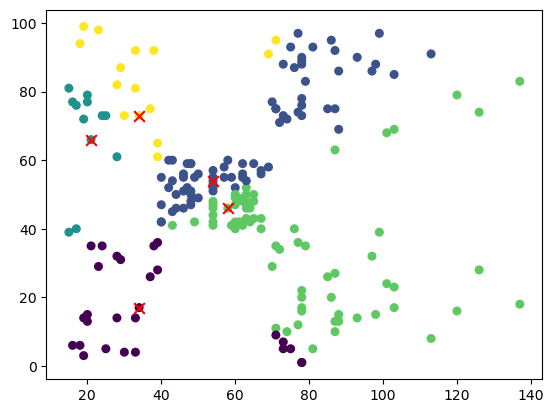

In [23]:
plot_clusters(x_y_tens, centroids, cluster_assignments)

In [24]:
def assign_to_nearest_centroid(data, centroids):
    distances = euclidean_dist(data.unsqueeze(1), centroids.unsqueeze(0))
    cluster_assignments = torch.argmin(distances, dim=1)
    return cluster_assignments

In [25]:
cluster_assignments

tensor([2, 2, 0, 2, 2, 2, 0, 4, 0, 2, 0, 4, 0, 2, 0, 2, 0, 2, 0, 4, 0, 2, 0, 2,
        0, 4, 0, 2, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
        1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 1,
        3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1,
        1, 3, 1, 4, 3, 1, 3, 4, 3, 1, 0, 1, 3, 1, 0, 1, 0, 1, 3, 1, 0, 1, 3, 1,
        3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 0, 1, 0, 1, 3, 1, 3, 1, 3, 1, 3, 1,
        3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3,
        3, 1, 3, 3, 3, 3, 3, 3], device='cuda:0')

In [26]:
new_centroids = torch.zeros_like(centroids)
new_centroids

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0', dtype=torch.float64)

In [27]:
test_count = 0
for i in range(centroids.shape[0]):
    assigned_points = x_y_tens[cluster_assignments == i]
    test_count += assigned_points.shape[0]
test_count

200

In [28]:
centroids

tensor([[34., 17.],
        [54., 54.],
        [21., 66.],
        [58., 46.],
        [34., 73.]], device='cuda:0', dtype=torch.float64)

In [29]:
def update_centroids(data, cluster_assignments, centroids): 
    new_centroids = torch.zeros_like(centroids)
    for i in range(centroids.shape[0]):
        assigned_points = data[cluster_assignments == i]
        if len(assigned_points) > 0:
            new_centroids[i] = torch.mean(assigned_points, dim=0)
    return new_centroids

In [30]:
update_centroids(x_y_tens, cluster_assignments, centroids)

tensor([[37.8148, 15.9259],
        [64.0658, 65.5658],
        [19.7500, 67.8333],
        [77.7857, 36.5000],
        [36.0000, 83.8667]], device='cuda:0', dtype=torch.float64)

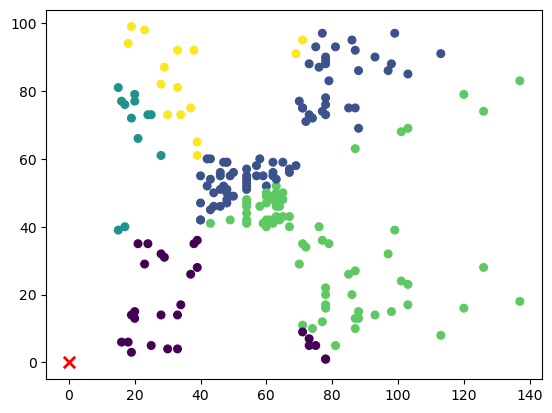

In [31]:
plot_clusters(x_y_tens, new_centroids, cluster_assignments)

## Create K-Means Loop

In [32]:
def k_means(data, centroids, iterations=10):
    for i in range(iterations):
        cluster_assignments = assign_to_nearest_centroid(data, centroids)
        new_centroids = update_centroids(data, cluster_assignments, centroids)
    cluster_assignments = assign_to_nearest_centroid(data, centroids)
    return cluster_assignments, new_centroids

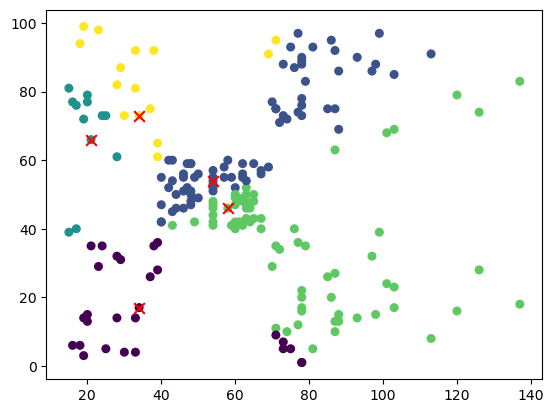

In [33]:
plot_clusters(x_y_tens, centroids, cluster_assignments)

In [34]:
cluster_assignments, centroids = k_means(x_y_tens, centroids)

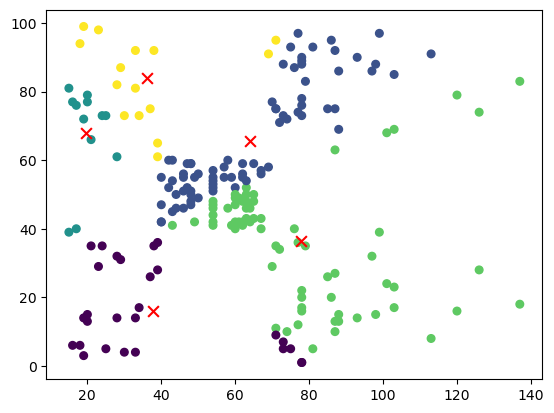

In [35]:
plot_clusters(x_y_tens, centroids, cluster_assignments)

In [36]:
centroids = og_centroids
cluster_assignments = og_cluster_assignments

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

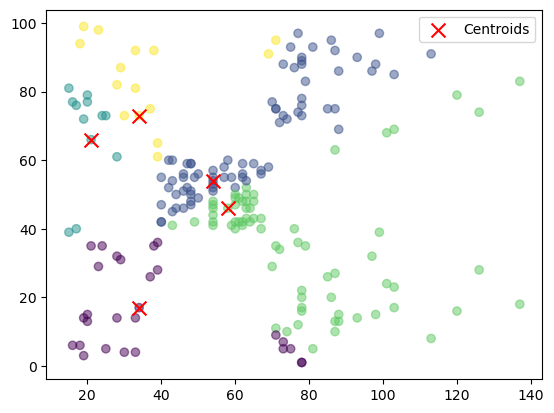

In [39]:
fig, ax = plt.subplots()

# Set up the initial plot
scatter = ax.scatter(np_detach(x_y_tens[:, 0]), np_detach(x_y_tens[:, 1]), c=np_detach(cluster_assignments), cmap='viridis', alpha=0.5)
centroid_plot = ax.scatter(np_detach(centroids[:, 0]), np_detach(centroids[:, 1]), c='red', marker='x', s=100, label='Centroids')
ax.legend()

In [ ]:
def init():
    return scatter, centroid_plot

In [ ]:
def update(frame):
    global data, centroids, cluster_assignments
    
    # Step 1: Assign data points to the nearest centroid
    cluster_assignments = assign_to_nearest_centroid(data, centroids)

    # Step 2: Update centroids
    updated_centroids = update_centroids(data, cluster_assignments, n_clusters)

    # Update plot
    scatter.set_array(cluster_assignments)
    centroid_plot.set_offsets(updated_centroids.numpy())
    centroids = updated_centroids
    
    return scatter, centroid_plot